In [9]:
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
from tensorly import random as rt

import scanpy as sc

import numpy as np
import string

import random

import cell2cell as c2c

data_path = '/data3/hratch/ccc_protocols/raw/'

In [1]:
scanorama

ModuleNotFoundError: No module named 'scanorama'

In [10]:
import tensorly as tl

# Authors: Hratch Baghdassarian <hmbaghdassarian@gmail.com>, Erick Armingol <earmingol14@gmail.com>
# similarity metrics for tensor decompositions


def correlation_index(
    factors_1: list, factors_2: list, tol: float = 5e-16, method: str = "stacked"
) -> float:
    """CorrIndex implementation to assess tensor decomposition outputs.
    From [1] Sobhani et al 2022 (https://doi.org/10.1016/j.sigpro.2022.108457).
    Metric is scaling and column-permutation invariant, wherein each column is a factor.
    Parameters
    ----------
    factors_1 : list
        The loading/factor matrices [A_1 ... A_N] for a low-rank tensor from its factors, output from first decomposition
    factors_2 : list
        The loading/factor matrices [A_1 ... A_N] for a low-rank tensor from its factors, output from second decomposition
    tol : float, optional
        Precision threshold below which to call the CorrIndex score 0, by default 5e-16
    method : str, optional
        Method to obtain the CorrIndex by comparing the A matrices from two decompositions, by default 'stacked'.
        Possible options are:
            - 'stacked' : The original method implemented in [1]. Here all A matrices from the same decomposition are
                          vertically concatenated, building a big A matrix for each decomposition.
            - 'max_score' : This computes the CorrIndex for each pair of A matrices (i.e. between A_1 in factors_1 and
                            factors_2, between A_2 in factors_1 and factors_2, and so on). Then the max score is
                            selected (the most conservative approach). In other words, it selects the max score among the
                            CorrIndexes computed dimension-wise.
            - 'min_score' : Similar to 'max_score', but the min score is selected (the least conservative approach).
            - 'avg_score' : Similar to 'max_score', but the avg score is selected.
    Returns
    -------
    score : float
         CorrIndex metric [0,1]; lower score indicates higher similarity between matrices
    """
    # check input factors shape
    for factors in [factors_1, factors_2]:
        if len({tl.shape(A)[1] for A in factors}) != 1:
            raise ValueError(
                "Factors should be a list of loading matrices of the same rank"
            )

    # check method
    options = ["stacked", "max_score", "min_score", "avg_score"]
    if method not in options:
        raise ValueError("The `method` must be either option among {}".format(options))

    if method == "stacked":
        # vertically stack loading matrices -- shape sum(tensor.shape)xR)
        X_1 = [tl.concatenate(factors_1, 0)]
        X_2 = [tl.concatenate(factors_2, 0)]
    else:
        X_1 = factors_1
        X_2 = factors_2

    for x1, x2 in zip(X_1, X_2):
        if tl.shape(x1) != tl.shape(x2):
            raise ValueError("Factor matrices should be of the same shapes")

    # normalize columns to L2 norm - even if ran decomposition with normalize_factors=True
    col_norm_1 = [tl.norm(x1, axis=0) for x1 in X_1]
    col_norm_2 = [tl.norm(x2, axis=0) for x2 in X_2]
    for cn1, cn2 in zip(col_norm_1, col_norm_2):
        if tl.any(cn1 == 0) or tl.any(cn2 == 0):
            raise ValueError("Column norms must be non-zero")
    X_1 = [x1 / cn1 for x1, cn1 in zip(X_1, col_norm_1)]
    X_2 = [x2 / cn2 for x2, cn2 in zip(X_2, col_norm_2)]

    corr_idxs = [
        _compute_correlation_index(x1, x2, tol=tol) for x1, x2 in zip(X_1, X_2)
    ]

    if method == "stacked":
        score = corr_idxs[0]
    elif method == "max_score":
        score = tl.max(corr_idxs)
    elif method == "min_score":
        score = tl.min(corr_idxs)
    elif method == "avg_score":
        score = tl.mean(corr_idxs)
    else:
        score = 1.0
    return score


def _compute_correlation_index(x1: list, x2: list, tol: float = 5e-16) -> float:
    """Computes the CorrIndex from the L2-normalized A matrices.
    Parameters
    ----------
    x1 : list
        A list containing normalized A matrix(ces) from the first tensor decomposition.
    x2 : list
        A list containing normalized A matrix(ces) from the first tensor decomposition.
    tol : float, optional
        Precision threshold below which to call the CorrIndex score 0, by default 5e-16
    Returns
    -------
    score : float
         CorrIndex metric [0,1]; lower score indicates higher similarity between matrices
    """
    # generate the correlation index input
    c_prod_mtx = tl.abs(tl.matmul(tl.conj(tl.transpose(x1)), x2))

    # correlation index scoring
    n_elements = tl.shape(c_prod_mtx)[1] + tl.shape(c_prod_mtx)[0]
    score = (1 / (n_elements)) * (
        tl.sum(tl.abs(tl.max(c_prod_mtx, 1) - 1))
        + tl.sum(tl.abs(tl.max(c_prod_mtx, 0) - 1))
    )
    if score < tol:
        score = 0
    return score

Test what adding a constant or squaring  data does to TCD

Conclusion: Changes decomposition results substantially

In [109]:
# create a random tensor
dims = (10, 10, 10, 100)
seed = 888
rank = 5

tensor = rt.random_tensor(dims, random_state = seed)# tl.tensor(np.random.normal(size = dims))

constant_shift = 10#abs(tensor.min())
tensor_shift = tensor + constant_shift
# factors = non_negative_parafac(tensor, rank = rank, random_state = seed, 
#                        init='svd', n_iter_max = 100, tol = 10e-7)
order_names = list()
for dim in dims:
    order_names.append([random.choice(string.ascii_letters) for i in range(dim)])
order_labels = ['Contexts', 'Sender', 'Receiver', 'LRs']

tensor = c2c.tensor.tensor.PreBuiltTensor(tensor, order_names = order_names, 
                                order_labels = order_labels)
tensor.compute_tensor_factorization(rank = rank, random_state = seed)


order_names = list()
for dim in dims:
    order_names.append([random.choice(string.ascii_letters) for i in range(dim)])
order_labels = ['Contexts', 'Sender', 'Receiver', 'LRs']

tensor_shift = c2c.tensor.tensor.PreBuiltTensor(tensor_shift, order_names = order_names, 
                                order_labels = order_labels)
tensor_shift.compute_tensor_factorization(rank = rank, random_state = seed)


print('The constant added is {:.3e}'.format(constant_shift))

# c2c.plotting.tensor_factors_plot(tensor)

# c2c.plotting.tensor_factors_plot(tensor_pos)

# c2c.tensor.correlation_index(tensor.factors, 
#                             tensor_shift.factors)

The constant added is 1.000e+01


In [45]:
# create a random tensor
dims = (3,3,3,3)
seed = 888
rank = 5

tensor_raw = rt.random_tensor(dims, random_state = seed)# tl.tensor(np.random.normal(size = dims))

# factors = non_negative_parafac(tensor, rank = rank, random_state = seed, 
#                        init='svd', n_iter_max = 100, tol = 10e-7)
order_names = list()
for dim in dims:
    order_names.append([random.choice(string.ascii_letters) for i in range(dim)])
order_labels = ['Contexts', 'Sender', 'Receiver', 'LRs']

tensor = c2c.tensor.tensor.PreBuiltTensor(tensor_raw, order_names = order_names, 
                                order_labels = order_labels)
tensor.compute_tensor_factorization(rank = rank, random_state = seed)


order_names = list()
for dim in dims:
    order_names.append([random.choice(string.ascii_letters) for i in range(dim)])
order_labels = ['Contexts', 'Sender', 'Receiver', 'LRs']

tensor_parafac = c2c.tensor.tensor.PreBuiltTensor(tensor_raw, order_names = order_names, 
                                order_labels = order_labels)
tensor_parafac.compute_tensor_factorization(rank = rank, random_state = seed, 
                                           tf_type = 'parafac')

# # shift by negative counts
# for k,v in tensor_parafac.factors.items():
#     tensor_parafac.factors[k] = v + abs(v.min().min())

# c2c.plotting.tensor_factors_plot(tensor)

# c2c.plotting.tensor_factors_plot(tensor_parafac)

# c2c.tensor.correlation_index(tensor.factors, 
#                             tensor_parafac.factors)

In [46]:
c2c.tensor.correlation_index(tensor.factors,  tensor_parafac.factors)

0.22095448208167998

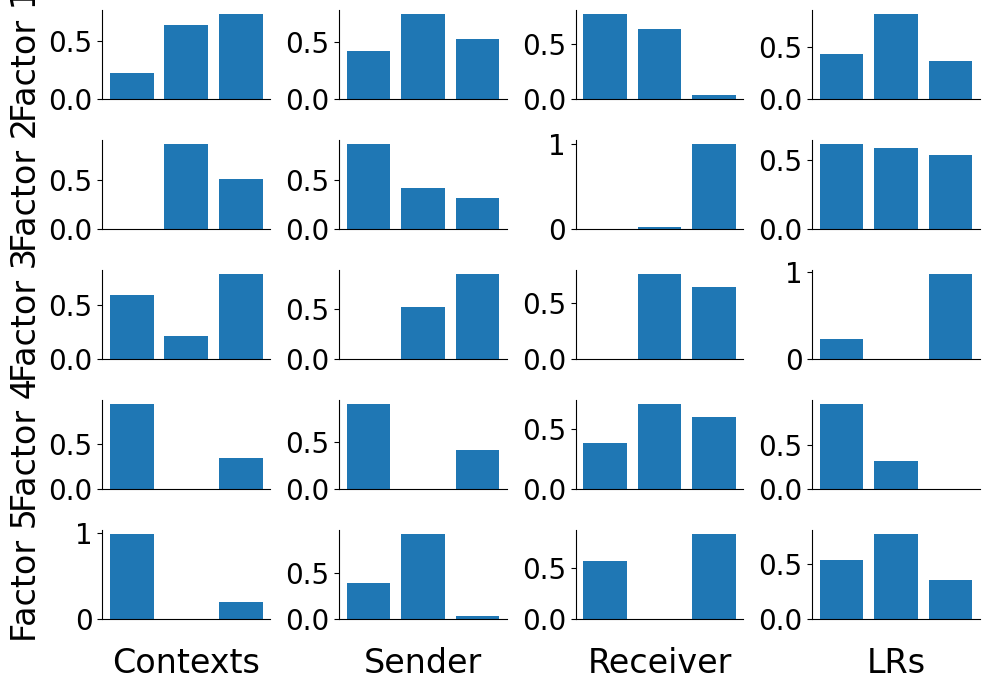

In [47]:
c2c.plotting.tensor_factors_plot(tensor);

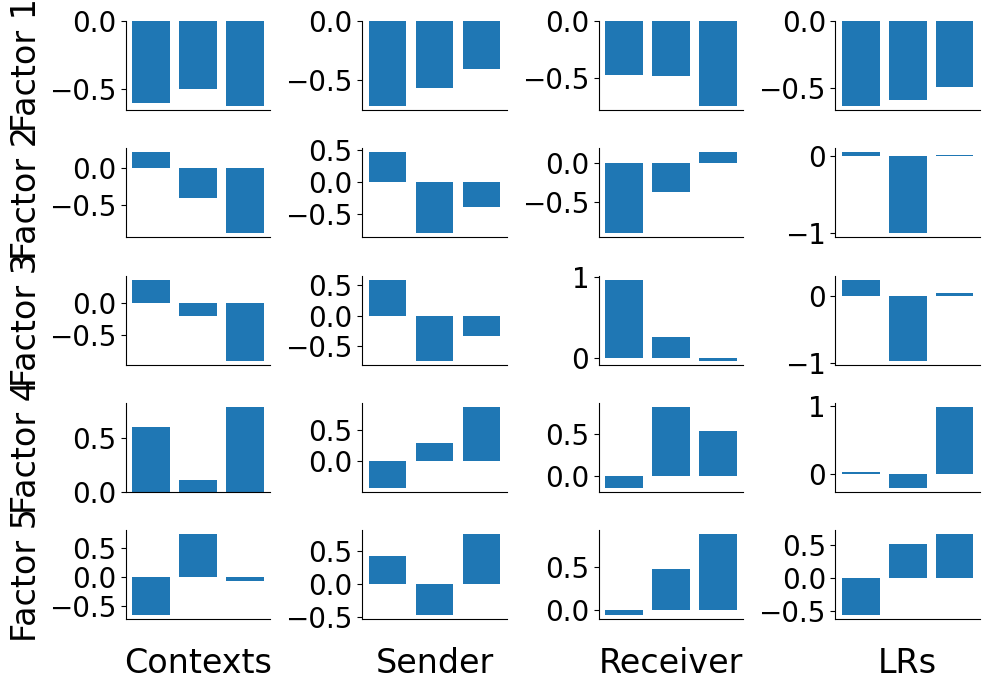

In [48]:
c2c.plotting.tensor_factors_plot(tensor_parafac);

Download the immune [data](https://figshare.com/ndownloader/files/25717328) from the batch-level integration [paper](https://www.nature.com/articles/s41592-021-01336-8)

In [ ]:
adata = sc.read_h5ad(data_path + 'Immune_ALL_human.h5ad')

In [2]:
import scanorama

In [ ]:
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['sample'] == batch,]

Error in glue(.Internal(R.home()), "library", "base", "R", "base", sep = .Platform$file.sep) : 
  4 arguments passed to .Internal(paste) which requires 3
Error: could not find function "attach"
Error: object '.ArgsEnv' not found
Fatal error: unable to initialize the JIT



In [ ]:
adata